In [1]:
# Convolutional neural network
%matplotlib inline
import pickle


def unpickle(file):
    with open(file, "rb") as file_handle:
        dict = pickle.load(file_handle, encoding='latin1')
    return dict


In [2]:
import numpy as np


def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized


def read():
    names = unpickle('./data/cifar-10-batches-py/batches.meta')['label_names']
    print("names: ", names)
    data, labels = [], []
    for i in range(1, 6):
        filename = './data/cifar-10-batches-py/data_batch_'+str(i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            batch_data = unpickle(filename)
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data.astype(np.float32)
    return names, data, labels

names, data, labels = read()


names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(50000, 3072) (50000,)


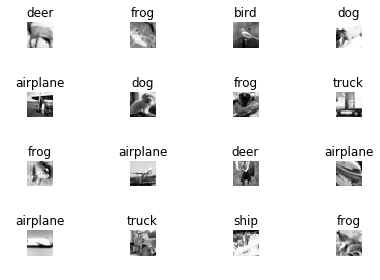

In [3]:
import matplotlib.pyplot as plt
import random


def display_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 4, 4
    random_ixs = random.sample(range(len(data)), rows*cols)
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        j = random_ixs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24, 24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

display_some_examples(names, data, labels)



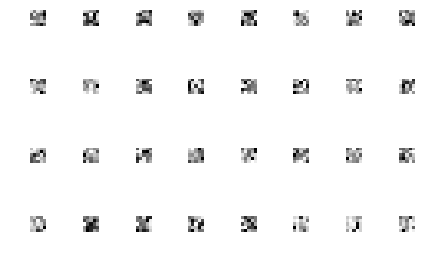

In [4]:
import tensorflow as tf


W = tf.Variable(tf.random_normal((5, 5, 1, 32), dtype=tf.float64))


def show_weights(W):
    plt.figure()
    rows, cols = 4, 8
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        img = W[:, :, 0, i]
        plt.imshow(img, cmap='Greys_r', interpolation=None)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    w_val = sess.run(W)
    show_weights(w_val)


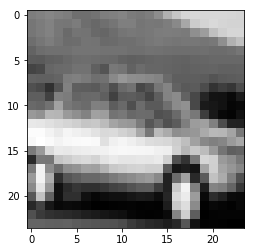

(1, 24, 24, 32)


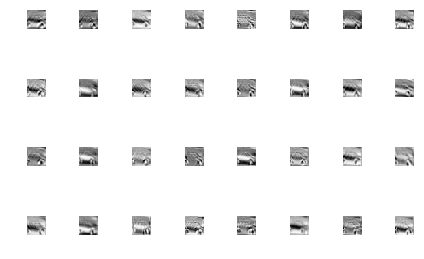

(1, 24, 24, 32)
(1, 24, 24, 32)


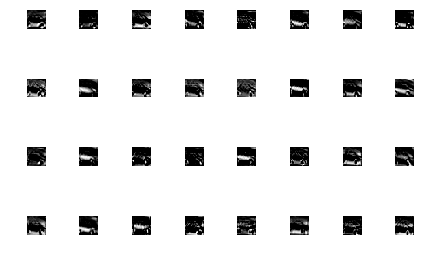

(1, 24, 24, 32)
(1, 12, 12, 32)


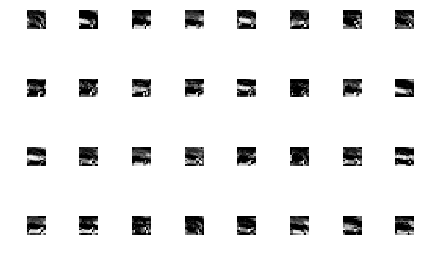

(1, 12, 12, 32)


In [5]:
def show_conv_results(data):
    plt.figure()
    rows, cols = 4, 8
    print(data.shape)
    for i in range(np.shape(data)[3]):
        plt.subplot(rows, cols, i+1)
        img = data[0, :, :, i]
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


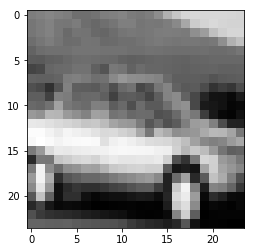

(1, 24, 24, 32)


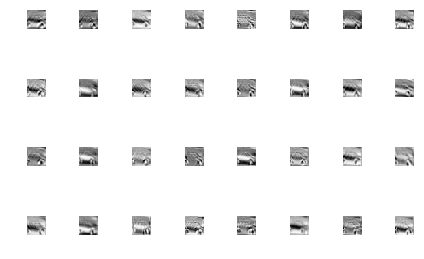

(1, 24, 24, 32)
(1, 24, 24, 32)


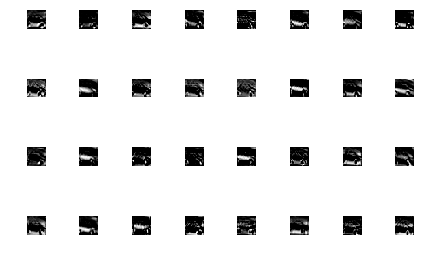

(1, 24, 24, 32)
(1, 12, 12, 32)


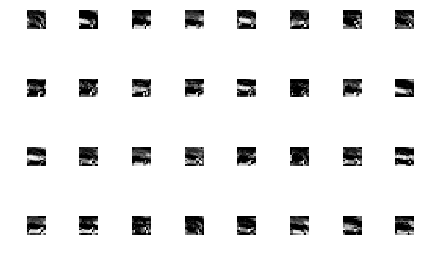

(1, 12, 12, 32)


In [6]:
raw_data = data[4, :]
raw_image = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_image, cmap='Greys_r')
plt.show()

x = tf.reshape(raw_data, [-1, 24, 24, 1])

b = tf.Variable(tf.random_normal([32], dtype=tf.float64))

conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_bias = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_bias)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_results(conv_val)
    print(np.shape(conv_val))
    
    conv_out_val = sess.run(conv_out)
    show_conv_results(conv_out_val)
    print(np.shape(conv_out_val))
    
k = 2
maxpool = tf.nn.max_pool(conv_out, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    maxpool_val = sess.run(maxpool)
    show_conv_results(maxpool_val)
    print(np.shape(maxpool_val))


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

names, data, labels = read()

x = tf.placeholder(tf.float32, shape=(None, 24*24))
y = tf.placeholder(tf.float32, shape=(None, len(names)))

W1 = tf.Variable(tf.random.normal([5, 5, 1, 64]))
b1 = tf.Variable(tf.random.normal([64]))

W2 = tf.Variable(tf.random.normal([5, 5, 64, 64]))
b2 = tf.Variable(tf.random.normal([64]))

W3 = tf.Variable(tf.random.normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random.normal([1024]))

w_out = tf.Variable(tf.random.normal([1024, len(names)]))
b_out = tf.Variable(tf.random.normal([len(names)]))


def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_bias =tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_bias)
    return conv_out


def maxpool_layer(conv, k=2):
    maxpool_layer = tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return maxpool_layer


def model():
    x_reshaped = tf.reshape(x, [-1, 24, 24, 1])
    
    conv_out_1 = conv_layer(x_reshaped, W1, b1)
    norm_1 = tf.nn.lrn(conv_out_1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    maxpool_out_1 = maxpool_layer(norm_1)
    
    conv_out_2 = conv_layer(maxpool_out_1, W2, b2)
    norm_2 = tf.nn.lrn(conv_out_2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    maxpool_out_2 = maxpool_layer(norm_2)
    
    maxpool_reshaped = tf.reshape(maxpool_out_2, [ -1 , W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    out = tf.add(tf.matmul(local_out, w_out), b_out)
    return out

model_op = model()

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

correct_predicitons = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predicitons, dtype=tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = 200
    for j in range(1000):
        print("Epoch:", j)
        for i in range(0, len(data), batch_size):
            batch_data = data[i: i+batch_size, :]
            batch_onehot_vals = onehot_vals[i: i+batch_size, :]
            _ , accuracy_val = sess.run([train_op, accuracy], feed_dict={x: batch_data, y: batch_onehot_vals})
            if i % 5000 == 0:
                print("Accuracy: {acc}".format(acc=accuracy_val))
        print("Epoch {e} completed".format(e=j))




Accuracy: 0.15000000596046448


Accuracy: 0.16500000655651093


Accuracy: 0.14000000059604645


Accuracy: 0.1899999976158142


Accuracy: 0.25


Accuracy: 0.17000000178813934


Accuracy: 0.23999999463558197


Accuracy: 0.2199999988079071


Accuracy: 0.25


Epoch 0 completed
Epoch: 1


Accuracy: 0.25999999046325684


Accuracy: 0.23000000417232513


Accuracy: 0.23000000417232513


Accuracy: 0.20499999821186066


Accuracy: 0.23499999940395355


Accuracy: 0.3199999928474426


Accuracy: 0.1899999976158142


Accuracy: 0.3050000071525574


Accuracy: 0.26499998569488525


Accuracy: 0.25999999046325684


Epoch 1 completed
Epoch: 2


Accuracy: 0.28999999165534973


Accuracy: 0.26499998569488525


Accuracy: 0.25999999046325684


Accuracy: 0.23499999940395355


Accuracy: 0.3050000071525574


Accuracy: 0.32499998807907104


Accuracy: 0.2549999952316284


Accuracy: 0.25


Accuracy: 0.28999999165534973


Accuracy: 0.2849999964237213


Epoch 2 completed
Epoch: 3


Accuracy: 0.2750000059604645
